In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [2]:
!pip install -q gdown
%cd {HOME}
!gdown '1f_N7hfSXMoVAD8WesBDI43QscEKYCuPd'

/content
Downloading...
From: https://drive.google.com/uc?id=1f_N7hfSXMoVAD8WesBDI43QscEKYCuPd
To: /content/video.mp4
100% 79.3M/79.3M [00:00<00:00, 148MB/s]


In [3]:
from collections import defaultdict
from typing import List

In [4]:
!pip install ultralytics supervision
from IPython import display
display.clear_output()

import ultralytics
from ultralytics import YOLO
import supervision as sv
import numpy as np

ultralytics.checks()

Ultralytics YOLOv8.0.229 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [5]:
SOURCE_VIDEO_PATH = f"{HOME}/video.mp4"

In [6]:
MODEL = "../model/vehicles.pt"

In [7]:
model = YOLO(MODEL)
tracker = sv.ByteTrack()
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 239MB/s]


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [8]:
selected_classes = [2, 3, 5, 6, 7]
CLASS_NAMES_DICT = {
    '2': 'cars',
    '3': 'motobikes',
    '5': 'bus',
    '6': 'train',
    '7': 'truck'
}

In [9]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info.resolution_wh

(1366, 768)

WARNING ⚠️ NMS time limit 0.550s exceeded


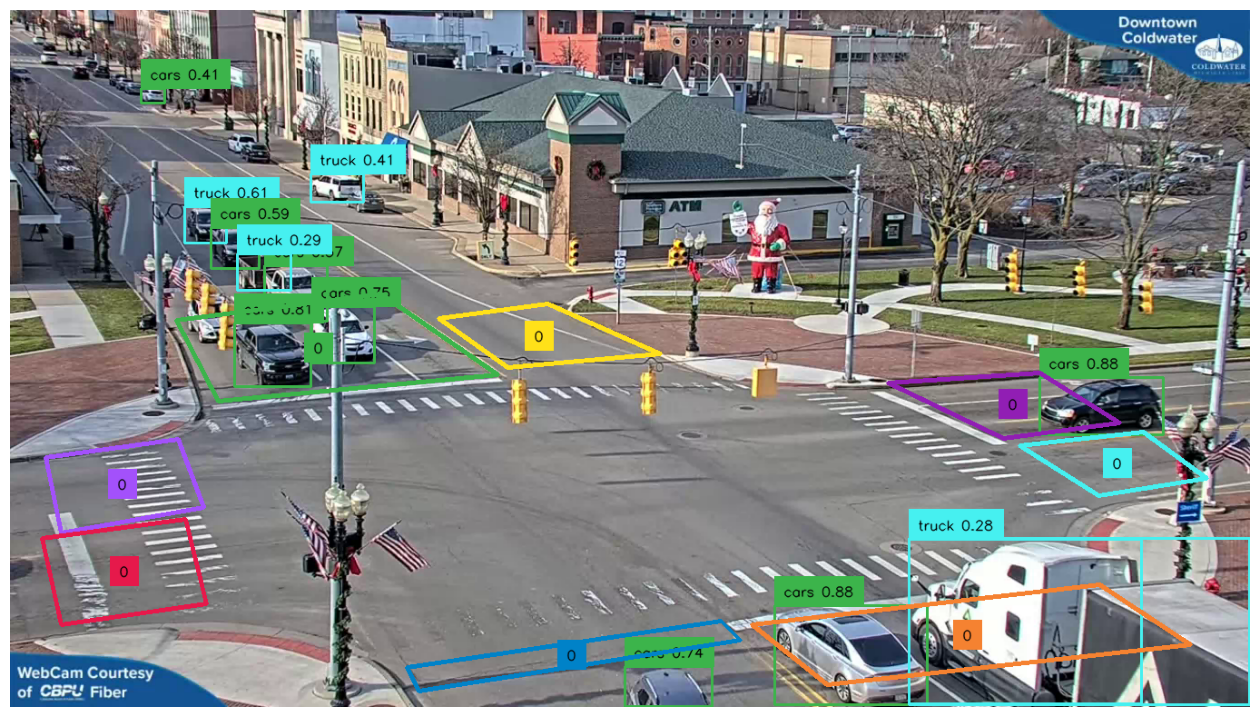

In [10]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
box_annotator = sv.BoxAnnotator(thickness=2, text_thickness=1, text_scale=0.5)
iterator = iter(generator)
frame = next(iterator)
results = model(frame, verbose=False)[0]
colors = sv.ColorPalette.default()
zones_coor = [
    np.array([[185,473],[213,548],[56,576],[39,493]], np.int32),
    np.array([[193,561],[216,654],[56,677],[35,582]], np.int32),
    np.array([[183,342],[408,313],[537,402],[229,431]], np.int32),
    np.array([[548,394],[716,379],[592,324],[472,340]], np.int32),
    np.array([[783,673],[437,724],[450,750],[804,694]], np.int32),
    np.array([[817,677],[1200,633],[1300,699],[900,743]], np.int32),
    np.array([[967,411],[1094,472],[1222,455],[1134,400]], np.int32),
    np.array([[1112,480],[1199,535],[1318,516],[1248,465]], np.int32)
]

zones = [
    sv.PolygonZone(
        polygon = zone_coor,
        frame_resolution_wh = video_info.resolution_wh,
        triggering_position = sv.Position.CENTER

    )
    for zone_coor
    in zones_coor
]

zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=3,
        text_thickness=1,
        text_scale=0.5
    )
    for index, zone
    in enumerate(zones)
]


detections = sv.Detections.from_ultralytics(results)
detections = detections[np.isin(detections.class_id, selected_classes)]

labels = [
    f"{CLASS_NAMES_DICT[str(class_id)]} {confidence:0.2f}"
    for _, _, confidence, class_id, _ in detections
]

anotated_frame=box_annotator.annotate(scene=frame,
                                      detections=detections,
                                      labels=labels)

for zone, zone_annotator in zip(zones, zone_annotators):
    anotated_frame = zone_annotator.annotate(scene=anotated_frame)

%matplotlib inline
sv.plot_image(anotated_frame, (16,16))

In [ ]:
TARGET_VIDEO_PATH = f"{HOME}/result.mp4"

In [ ]:
colors = sv.ColorPalette.default()
zones_coor = [
    np.array([[185,473],[213,548],[56,576],[39,493]], np.int32),
    np.array([[193,561],[216,654],[56,677],[35,582]], np.int32),
    np.array([[183,342],[408,313],[537,402],[229,431]], np.int32),
    np.array([[548,394],[716,379],[592,324],[472,340]], np.int32),
    np.array([[783,673],[437,724],[450,750],[804,694]], np.int32),
    np.array([[817,677],[1200,633],[1300,699],[900,743]], np.int32),
    np.array([[967,411],[1094,472],[1222,455],[1134,400]], np.int32),
    np.array([[1112,480],[1199,535],[1318,516],[1248,465]], np.int32)
]

zones = [
    sv.PolygonZone(
        polygon = zone_coor,
        frame_resolution_wh = video_info.resolution_wh,
        triggering_position = sv.Position.CENTER

    )
    for zone_coor
    in zones_coor
]

box_annotator = sv.BoxAnnotator(thickness=2,
                                text_thickness=1,
                                text_scale=0.5,
                                color = sv.Color.red())

counts = defaultdict(set)

def callback(frame: np.ndarray, index) -> np.ndarray:
    results = model(frame, agnostic_nms=True, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id, selected_classes)]
    detections = tracker.update_with_detections(detections)
    # labels = [
    #     f"{CLASS_NAMES_DICT[str(class_id)]}"
    #     for _, _, confidence, class_id, _
    #     in detections
    # ]
    # annotated_frame = trace_annotator.annotate(
    #     scene=frame.copy(),
    #     detections=detections
    # )
    annotated_frame=box_annotator.annotate(
        scene=frame.copy(),
        detections=detections,
        skip_label = True, #comment for using labels
        # labels=labels,  #uncomment for using labels
        )

    for i, zone in enumerate(zones):
        polygon = zone.polygon
        annotated_frame = sv.draw_polygon(
            annotated_frame,
            polygon,
            colors.by_idx(i)
        )

        map = zone.trigger(detections = detections)
        detections_in_zone : List[sv.Detections] = detections[map]
        for tracker_id in detections_in_zone.tracker_id:
            counts[i].add(tracker_id)
        count = len(counts[i])

        zone_center = sv.get_polygon_center(polygon = polygon)
        text_anchor = sv.Point(x=zone_center.x, y=zone_center.y)
        annotated_frame = sv.draw_text(
            annotated_frame,
            str(count),
            text_anchor,
            background_color = colors.by_idx(i)
        )


    return annotated_frame

sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)